In [1]:
import sys
import os
import requests
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.client import device_lib
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras_visualizer import visualizer
from IPython.display import display, Image

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

2025-10-16 13:08:50.214304: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-16 13:08:50.288215: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-16 13:08:50.290484: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-16 13:08:51.348497: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

planar_drone = import_local_or_github('planar_drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')
generate_training_data_utility = import_local_or_github('generate_training_data_utility', directory='../Utility')
keras_ann_utility = import_local_or_github('keras_ann_utility', directory='../Utility')
keras_advanced_utility = import_local_or_github('keras_advanced_utility', directory='../Utility')

/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


## Install utility

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
try:
    import nonlinear_estimation_utilities
    print('Package ' + 'nonlinear_estimation_utilities' + ' is already installed.')
    nonlinear_estimation_utilities.check_for_updates()
except:
    !pip install -qq git+https://github.com/florisvb/Nonlinear_and_Data_Driven_Estimation && echo "✓ nonlinear_estimation_utilities installed"
    import nonlinear_estimation_utilities
    nonlinear_estimation_utilities.check_for_updates()

Package nonlinear_estimation_utilities is already installed.
✓ You have the latest version (0.0.35)


## Install requirements

In [3]:
nonlinear_estimation_utilities.install_and_download_requirements.install_planar_drone_requirements()
nonlinear_estimation_utilities.install_and_download_requirements.install_neural_network_requirements()

Already installed: casadi
Already installed: do_mpc
Already installed: git+https://github.com/vanbreugel-lab/pybounds
Already installed: pynumdiff


2025-12-01 16:59:54.062635: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-01 16:59:54.130879: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-01 16:59:55.289367: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Already installed: tensorflow
Already installed: keras
Attempting to pip install: keras-visualizer
✓ pynumdiff 0.1.4.dev258+g5d960720f meets requirement >=0.1.4
Already installed: pynumdiff


## Install modules

In [4]:
nonlinear_estimation_utilities.load_planar_drone_modules()
nonlinear_estimation_utilities.load_neural_network_modules()

## Import modules

In [5]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [6]:
import keras
import tensorflow as tf

In [7]:
import pynumdiff

In [8]:
from nonlinear_estimation_utilities import plot_utility
from nonlinear_estimation_utilities import planar_drone
from nonlinear_estimation_utilities import generate_training_data_utility
from nonlinear_estimation_utilities import terrain_and_optic_flow_utility
from nonlinear_estimation_utilities import keras_ann_utility
from nonlinear_estimation_utilities import keras_advanced_utility

from nonlinear_estimation_utilities.plot_utility import plot_tme

# Download, load, clean, and add noise to data as in Lesson 12.A

In [9]:
generate_training_data_utility.download_data('planar_drone_trajectories.zip')

Fetching from: https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Data/planar_drone_trajectories.zip
Successfully downloaded planar_drone_trajectories.zip (29316396 bytes)
unzipping...


In [10]:
traj_list = generate_training_data_utility.load_trajectory_data('planar_drone_trajectories')

Number of trajectories: 
3001


In [11]:
traj_list = generate_training_data_utility.clean_trajectory_data(traj_list)

Number of good trajectories: 
2924


In [12]:
traj_list = generate_training_data_utility.add_noise_to_trajectory_data(traj_list, 0.02)

# Get derivatives

In [13]:
state_names =  ['theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot'] 

In [14]:
for i, traj in enumerate(traj_list):
    for state in state_names:
        state_smooth, ddt_state = pynumdiff.savgoldiff(traj[state], 0.1, degree=3, window_size=5, smoothing_win=5)
        traj['ddt_' + state] = ddt_state
    traj_list[i] = traj

# Build augmented data frames

This demo shows how to include an auxiliary time delay embedding. If you dynamics truly are given by:

$$
\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x}, \mathbf{u})
$$

Then this is uneccessary. But if your dynamics contain hysteresis you may need this functionality. 

In [15]:
state_names =  ['theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot'] 
control_names = ['j1', 'j2']
output_names = ['ddt_' + state for state in state_names] #'theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot']

In [16]:
state_offsets = [0, -1] 
control_offsets = [0, -1] 
output_offsets = [0]

In [17]:
trim_edges = 4 # drop the first and last of these frames to remove bad derivatives and artifacts

In [18]:
traj_augment_list = []
for traj in traj_list:
    traj_augment = keras_ann_utility.collect_offset_rows(traj[trim_edges:-1*trim_edges], 
                                                         states=state_names, 
                                                         controls=control_names, 
                                                         outputs=output_names, 
                                                         state_offsets=state_offsets, 
                                                         control_offsets=control_offsets, 
                                                         output_offsets=output_offsets)
    traj_augment_list.append(traj_augment)

# merge all trajectories
traj_augment_all = pd.concat(traj_augment_list, ignore_index=True)

# show the data frame so you can confirm it looks right
np.round(traj_augment_all, 4)

,theta_offset_0,theta_dot_offset_0,x_offset_0,x_dot_offset_0,z_offset_0,z_dot_offset_0,theta_offset_-1,theta_dot_offset_-1,x_offset_-1,x_dot_offset_-1,...,j1_offset_0,j2_offset_0,j1_offset_-1,j2_offset_-1,ddt_theta_offset_0,ddt_theta_dot_offset_0,ddt_x_offset_0,ddt_x_dot_offset_0,ddt_z_offset_0,ddt_z_dot_offset_0
0,-0.7579,-0.0154,-7.8459,9.9296,8.2519,-0.9719,-0.7558,0.0397,-8.6564,7.3786,...,1.1196,36.1019,0.0263,35.7085,0.7569,15.8355,9.7964,24.1926,-0.7780,16.2843
1,-0.6735,2.7795,-6.7131,12.3528,8.2145,0.7206,-0.7579,-0.0154,-7.8459,9.9296,...,1.7733,34.7486,1.1196,36.1019,3.0861,29.3295,12.2563,17.9593,0.8891,19.1723
2,-0.1517,7.2544,-5.3561,13.7920,8.4186,2.8537,-0.6735,2.7795,-6.7131,12.3528,...,-0.7827,32.6841,1.7733,34.7486,5.2115,8.7989,13.3683,3.8790,2.8189,20.7326
3,0.4790,5.3100,-3.9797,13.1710,8.7754,5.0591,-0.1517,7.2544,-5.3561,13.7920,...,-1.9888,29.8944,-0.7827,32.6841,4.4286,-25.8189,12.6278,-10.9008,4.7829,17.3688
4,0.7906,0.3714,-2.8228,11.3168,9.3868,6.3894,0.4790,5.3100,-3.9797,13.1710,...,-0.2629,26.3092,-1.9888,29.8944,1.8182,-25.1416,11.1131,-17.5530,6.2981,11.5537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236839,-0.2260,1.0487,0.3383,0.6642,3.2538,-3.1918,-0.2554,0.2493,0.3124,0.4815,...,0.0617,10.0841,0.3335,7.9922,0.6840,4.6731,0.5855,1.6278,-3.0154,-0.7900
236840,-0.1197,1.1776,0.4168,0.8087,2.9755,-3.1786,-0.2260,1.0487,0.3383,0.6642,...,-0.1063,12.1801,0.0617,10.0841,0.9680,-0.7211,0.8664,1.1104,-2.9611,1.2090
236841,-0.0190,0.8410,0.5315,0.8976,2.6649,-2.9501,-0.1197,1.1776,0.4168,0.8087,...,-0.1767,14.1096,-0.1063,12.1801,0.8616,-3.8428,0.8737,0.2333,-2.9128,3.1951
236842,0.0583,0.3302,0.5851,0.8624,2.3852,-2.5497,-0.0190,0.8410,0.5315,0.8976,...,-0.1454,15.7207,-0.1767,14.1096,0.4504,-4.0013,0.8340,-0.7246,-2.6322,5.1754


In [19]:
n_state = len(state_names)
n_control = len(control_names)
n_output = len(output_names)
delay_embedding = len(state_offsets)

print('States:', n_state)
print('Controls:', n_control)
print('Outputs:', n_output)
print('Delay embedding:', delay_embedding)

States: 6
Controls: 2
Outputs: 6
Delay embedding: 2


### Seperate inputs, controls, and outputs

In [20]:
# Augmented state data
X = traj_augment_all.iloc[:, 0:n_state*delay_embedding]
X

,theta_offset_0,theta_dot_offset_0,x_offset_0,x_dot_offset_0,z_offset_0,z_dot_offset_0,theta_offset_-1,theta_dot_offset_-1,x_offset_-1,x_dot_offset_-1,z_offset_-1,z_dot_offset_-1
0,-0.757942,-0.015381,-7.845884,9.929649,8.251878,-0.971881,-0.755783,0.039666,-8.656416,7.378604,8.369142,-2.487873
1,-0.673469,2.779523,-6.713088,12.352775,8.214491,0.720579,-0.757942,-0.015381,-7.845884,9.929649,8.251878,-0.971881
2,-0.151671,7.254363,-5.356108,13.791979,8.418576,2.853710,-0.673469,2.779523,-6.713088,12.352775,8.214491,0.720579
3,0.479026,5.310023,-3.979736,13.170991,8.775380,5.059094,-0.151671,7.254363,-5.356108,13.791979,8.418576,2.853710
4,0.790562,0.371410,-2.822814,11.316829,9.386808,6.389447,0.479026,5.310023,-3.979736,13.170991,8.775380,5.059094
...,...,...,...,...,...,...,...,...,...,...,...,...
236839,-0.226013,1.048691,0.338349,0.664227,3.253840,-3.191777,-0.255397,0.249329,0.312440,0.481512,3.575033,-3.030200
236840,-0.119735,1.177647,0.416841,0.808719,2.975527,-3.178633,-0.226013,1.048691,0.338349,0.664227,3.253840,-3.191777
236841,-0.019035,0.840998,0.531490,0.897622,2.664928,-2.950130,-0.119735,1.177647,0.416841,0.808719,2.975527,-3.178633
236842,0.058347,0.330215,0.585061,0.862437,2.385237,-2.549691,-0.019035,0.840998,0.531490,0.897622,2.664928,-2.950130


In [21]:
# Augmented control data
U = traj_augment_all.iloc[:, n_state*delay_embedding:n_state*delay_embedding+n_control*delay_embedding]
U

,j1_offset_0,j2_offset_0,j1_offset_-1,j2_offset_-1
0,1.119650,36.101916,0.026258,35.708464
1,1.773257,34.748629,1.119650,36.101916
2,-0.782661,32.684091,1.773257,34.748629
3,-1.988831,29.894431,-0.782661,32.684091
4,-0.262917,26.309218,-1.988831,29.894431
...,...,...,...,...
236839,0.061682,10.084106,0.333451,7.992165
236840,-0.106327,12.180088,0.061682,10.084106
236841,-0.176681,14.109617,-0.106327,12.180088
236842,-0.145354,15.720694,-0.176681,14.109617


In [22]:
# Output data
Y = traj_augment_all.iloc[:, n_state*delay_embedding+n_control*delay_embedding:]
Y

,ddt_theta_offset_0,ddt_theta_dot_offset_0,ddt_x_offset_0,ddt_x_dot_offset_0,ddt_z_offset_0,ddt_z_dot_offset_0
0,0.756906,15.835452,9.796393,24.192568,-0.777968,16.284297
1,3.086086,29.329529,12.256323,17.959257,0.889054,19.172262
2,5.211454,8.798874,13.368300,3.879003,2.818892,20.732624
3,4.428650,-25.818893,12.627776,-10.900775,4.782886,17.368775
4,1.818165,-25.141602,11.113135,-17.552968,6.298056,11.553728
...,...,...,...,...,...,...
236839,0.683984,4.673079,0.585517,1.627787,-3.015402,-0.790032
236840,0.967989,-0.721149,0.866384,1.110396,-2.961132,1.208996
236841,0.861573,-3.842811,0.873694,0.233310,-2.912833,3.195068
236842,0.450366,-4.001321,0.833966,-0.724605,-2.632155,5.175437


### Organize the data

In [23]:
# Organize the data so we have the core data, and augmented (delay embedded) data
core_data = np.hstack((X.values[:, 0:n_state], U.values[:, 0:n_control]))
aux_data = np.hstack((X.values[:, n_state:], U.values[:, n_control:]))
output_data = Y.values

In [24]:
all_data = {'X_core_train': core_data,
        'X_aux_train': aux_data,
        'y_train': output_data}

### Split up data into testing and training subsets

In [25]:
# split the data
data = keras_advanced_utility.prepare_train_test_split(all_data, test_size=0.2, random_state=42)

Data split complete:
  Training samples: 189475 (80%)
  Test samples: 47369 (20%)
  Core features: 8
  Aux features: 8
  Output dimension: 6


In [26]:
data.keys()

dict_keys(['X_core_train', 'X_core_test', 'X_aux_train', 'X_aux_test', 'y_train', 'y_test'])

# Build model architecture

In [27]:
# Define model architecture
core_architecture = [
    {'units': 64, 'activation': 'tanh'},
    {'units': 64, 'activation': 'tanh'}
]

aux_architecture = [
    {'units': 64, 'activation': 'tanh'}
]

combined_architecture = [
    {'units': 32, 'activation': 'linear'},
    {'units': output_data.shape[1]}  # Output layer
]

input_architecture = {'core_input_dim': data['X_core_train'].shape[1],
                      'aux_input_dim': data['X_aux_train'].shape[1]}


training_parameters = {'jacobian_weight': 1.0,
                       'sv_weight': 0.01}

In [28]:
# Build model
print("\nBuilding model...")
model, dropout_layer = keras_advanced_utility.build_auxiliary_dropout_model(
    core_input_dim=input_architecture['core_input_dim'],
    aux_input_dim=input_architecture['aux_input_dim'],
    core_architecture=core_architecture,
    aux_architecture=aux_architecture,
    combined_architecture=combined_architecture,
    jacobian_weight=training_parameters['jacobian_weight'],
    sv_weight=training_parameters['sv_weight']
)


Building model...


2025-12-01 17:03:29.911314: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [29]:
# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='mse', 
    metrics=['mae']
)
model.summary()

Model: "jacobian_regularized_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 core_features (InputLayer)  [(None, 8)]                  0         []                            
                                                                                                  
 aux_features (InputLayer)   [(None, 8)]                  0         []                            
                                                                                                  
 core_dense_0 (Dense)        (None, 64)                   576       ['core_features[0][0]']       
                                                                                                  
 aux_dropout (Dropout)       (None, 8)                    0         ['aux_features[0][0]']        
                                                                         

In [30]:
# Train with curriculum learning
print("\nTraining with curriculum learning...")
history, curriculum_callback, X_core_val, X_aux_val, y_val = keras_advanced_utility.train_with_curriculum(
    model=model,
    dropout_layer=dropout_layer,
    X_core_train=data['X_core_train'],
    X_aux_train=data['X_aux_train'],
    y_train=data['y_train'],
    validation_split=0.2,
    epochs=200,
    batch_size=128,
    initial_dropout=0.2, # start with dropping out 20% of the auxilliary inputs
    final_dropout=0.99,  # end with dropping out 99% of the auxiliary inputs << if you plan to keep aux inputs, keep this low
    warmup_fraction=0.5,
    verbose=1
)


Training with curriculum learning...
Curriculum learning schedule:
  Total epochs: 200
  Warmup epochs: 100 (50% of training)
  Dropout: 0.20 → 0.99
  Final dropout reached at epoch 100
Epoch 1/200
1185/1185 [==============================] - 9s 6ms/step - loss: 22.2502 - mae: 2.5380 - jacobian_smoothness: 1.8773e-04 - sv_loss: 0.0764 - val_loss: 6.0697 - val_mae: 1.4175 - val_jacobian_smoothness: 0.0000e+00 - val_sv_loss: 0.0000e+00 - dropout_rate: 0.2000 - val_mae_with_aux: 1.4175 - val_mae_without_aux: 2.0413
Epoch 2/200
1185/1185 [==============================] - 7s 6ms/step - loss: 5.6395 - mae: 1.3399 - jacobian_smoothness: 5.5374e-04 - sv_loss: 2.2220e-07 - val_loss: 3.4815 - val_mae: 1.0252 - val_jacobian_smoothness: 0.0000e+00 - val_sv_loss: 0.0000e+00 - dropout_rate: 0.2079 - val_mae_with_aux: 1.0252 - val_mae_without_aux: 1.6386
Epoch 3/200
1185/1185 [==============================] - 7s 6ms/step - loss: 3.7029 - mae: 1.0651 - jacobian_smoothness: 6.3222e-04 - sv_loss: 0.0

# Visualize training and performance


VALIDATION SET PERFORMANCE:
MAE without auxiliary features: 0.8500
MAE with auxiliary features:    0.4455
✓ Aux features improve performance by 47.58%

TEST SET PERFORMANCE:
MAE without auxiliary features: 0.8534
MAE with auxiliary features:    0.4486
✓ Aux features improve performance by 47.43%

Generating visualizations...


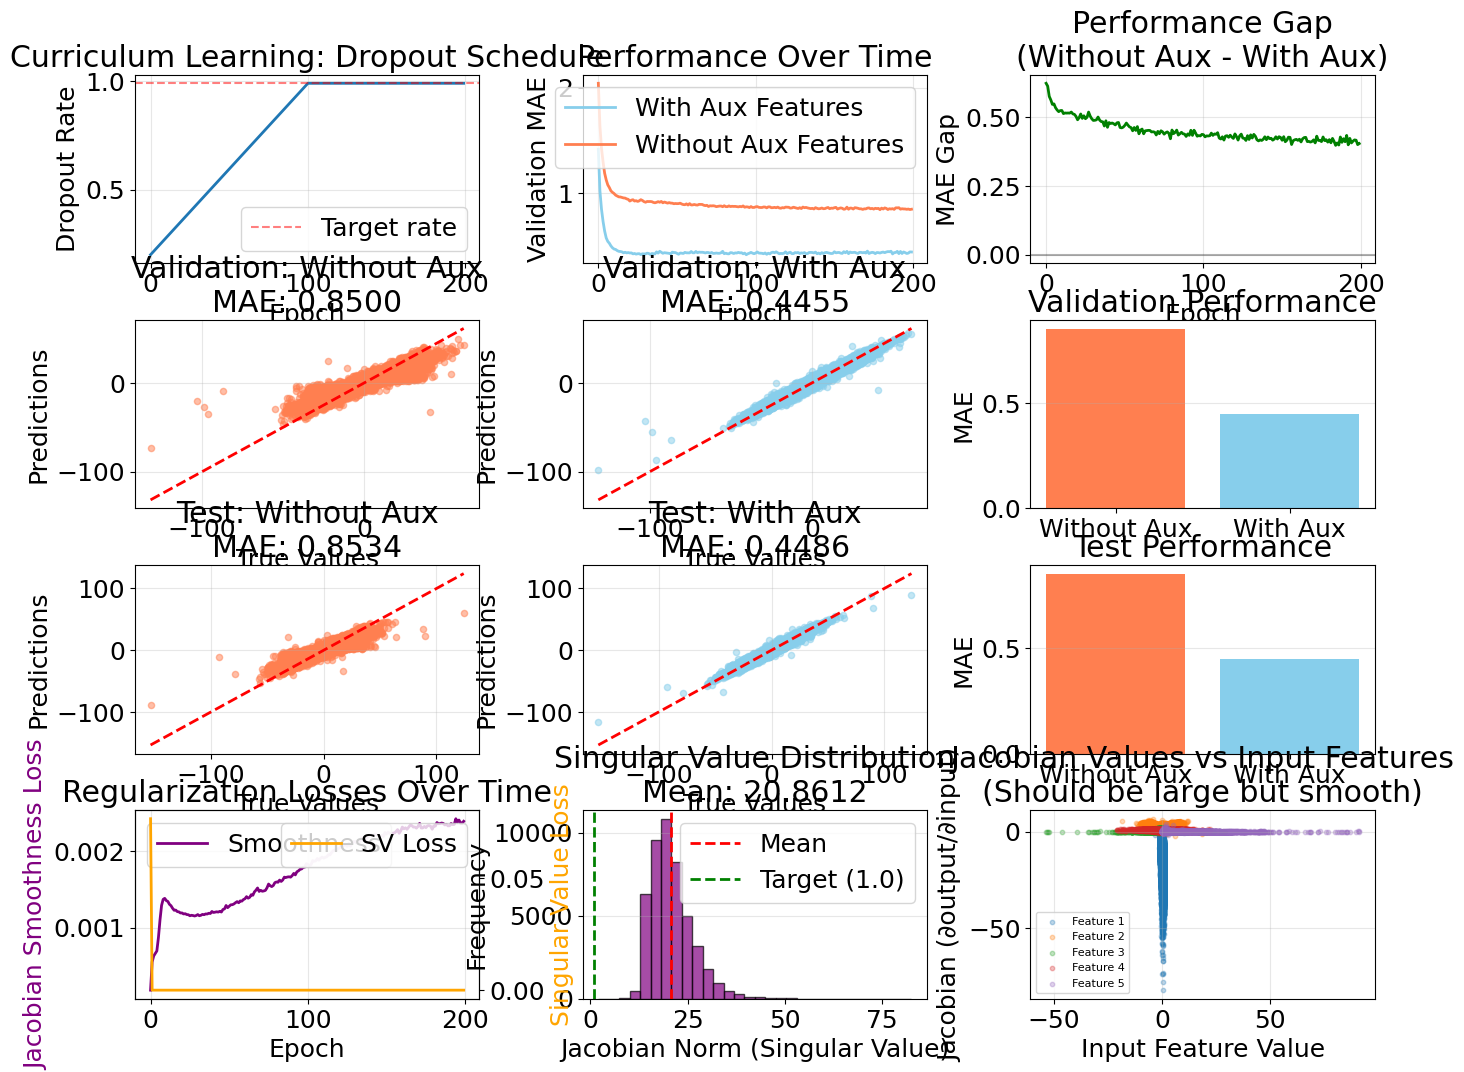


SUMMARY
Final dropout rate: 0.99
Mean Jacobian norm: 1.7729

Training complete! Check 'curriculum_dropout_results.png' for visualizations.


In [31]:
# Evaluate on validation and test sets
val_results = keras_advanced_utility.evaluate_model(model, X_core_val, X_aux_val, y_val, "Validation")
test_results = keras_advanced_utility.evaluate_model(model, data['X_core_test'], data['X_aux_test'], 
                               data['y_test'], "Test")

# Visualize results
print("\nGenerating visualizations...")
keras_advanced_utility.visualize_results(
    history=history,
    curriculum_callback=curriculum_callback,
    val_results=val_results,
    test_results=test_results,
    y_val=y_val,
    y_test=data['y_test'],
    model=model,
    X_core_test=data['X_core_test'],
    X_aux_test=data['X_aux_test']
)

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Final dropout rate: {curriculum_callback.dropout_history[-1]:.2f}")
print(f"Mean Jacobian norm: {np.linalg.norm(np.random.randn(10, 5), axis=1).mean():.4f}")
print("\nTraining complete! Check 'curriculum_dropout_results.png' for visualizations.")

In [32]:
keras_advanced_utility.save_model_complete(
    model=model,
    filepath='smooth_dynamics_model_continuous',  # No extension needed
    core_architecture=core_architecture,
    aux_architecture=aux_architecture,
    combined_architecture=combined_architecture,
    input_architecture=input_architecture,
    training_parameters=training_parameters
)

Saving weights layer-by-layer for compatibility...
  Saved layer: core_dense_0
  Saved layer: core_dense_1
  Saved layer: aux_dense_0
  Saved layer: combined_dense_0
  Saved layer: combined_dense_1
✓ Saved weights to: smooth_dynamics_model_continuous.weights.h5
✓ Saved configuration to: smooth_dynamics_model_continuous.config.json

Model saved successfully!
To load: model, dropout_layer, config = load_model_complete('smooth_dynamics_model_continuous')


# Check predicted vs true for a specific state

(For debugging if needed)

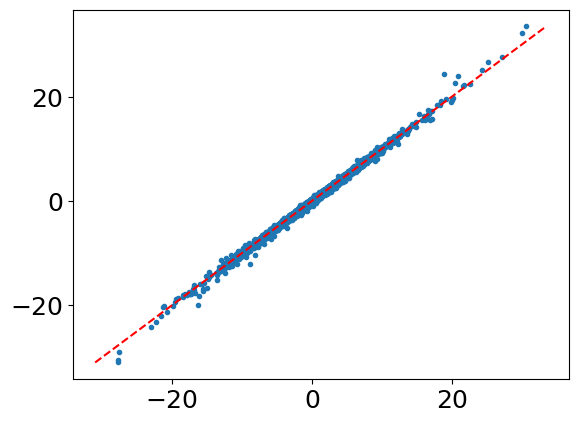

In [33]:
state = 4
plt.plot(val_results['predictions_without_aux'][:,state], y_val[:,state], '.')
l = np.linspace(np.min(y_val[:, state]), np.max(y_val[:,state]))
plt.plot(l, l, '--', color='red')